In [113]:
#### Julia 1.7.3 #####
# using LinearAlgebra
# using PyPlot
# using RandomMatrix
# using ITensors
# # using TensorOperations
using LsqFit
using ITensors, PyPlot, Polynomials

# Numerical many-body methods - Problem Set 3 
## (DMRG)
Noam Ophir

# $J_1-J_2$ spin-1/2 chain
*In this problem we will revisit the spin-1/2 antiferromagnetic $J_1-J_2$ chain discussed in Problem Set 1, given by the Hamiltonian*
$$
H
=
J_1\sum_i\vec{S}_i\cdot\vec{S}_{i+1}+J_2\sum_i\vec{S}_i\cdot\vec{S}_{i+2}
$$
*Recall that the model exhibits a phase transition between a gapless and a dimerized phase at $g_c\simeq 0.241$, where $g$ is the dimensionless ratio $J_2/J_1$.*

*We will now solve the problem using DMRG and employing the ITensor library. In sections 2,3 below use values of $g\leq1/2$. (For $g > 1/2$ the system is still dimerized but exhibitis incommensurate spin-spin correlations, reminiscent of the classical ordering, which can give rise to large finite-size effects.)*

## 1-1
*Generalize the construction of the Heisenberg Hamiltonian discussed in class to allow for a finite $J_2$ term.*

In [5]:
function J1J2Hamiltonian(sites, J2)
    N = length(sites)
    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the 1D quantum system
    for j = 1:N-1
        # Heisenberg interaction term (Sz-Sz)
        ampo += "Sz", j, "Sz", j+1
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += 1/2, "S+", j, "S-", j+1
        ampo += 1/2, "S-", j, "S+", j+1
    end
    for j = 1:N-2
        # Heisenberg interaction term (Sz-Sz)
        ampo += J2, "Sz", j, "Sz", j+2
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += J2/2, "S+", j, "S-", j+2
        ampo += J2/2, "S-", j, "S+", j+2
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)
    return H
end

# Number of sites in the 1D quantum system
N = 100

# Generate an index set representing quantum sites with spin S=1/2, conserving quantum numbers
sites = siteinds("S=1/2", N; conserve_qns=true)

J2 = 1.0
H = J1J2Hamiltonian(sites, J2)

flux(psi0) = QN("Sz",0)


MPO
[1] ((dim=5|id=1|"Link,l=1") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 1
 3: QN("Sz",0) => 1
 4: QN("Sz",-2) => 1
 5: QN("Sz",0) => 1, (dim=2|id=571|"S=1/2,Site,n=1")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=571|"S=1/2,Site,n=1") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[2] ((dim=5|id=1|"Link,l=1") <In>
 1: QN() => 1
 2: QN("Sz",2) => 1
 3: QN("Sz",0) => 1
 4: QN("Sz",-2) => 1
 5: QN("Sz",0) => 1, (dim=8|id=533|"Link,l=2") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=445|"S=1/2,Site,n=2")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=445|"S=1/2,Site,n=2") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[3] ((dim=8|id=533|"Link,l=2") <In>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=8|id=452|"Link,l=3") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=956|"S=1/2,Site,n

## 1-2
*Perform finite-size scaling of the triplet gap (i.e. the energy gap between the ground state in the $S^z = 0$ sector to the lowest state in the $S^z = 1$ sector) for different values of $g$ across the phase transition. To find the lowest energy state in each $S^z$ sector you will need to make sure that the initial state is in the same $S^z$ sector. You can now easily access system sizes of up to $N = 100$ sites (performing e.g. 10 sweeps with bond dimensions of order 100), but to clearly observe a finite gap for $g > g_c$ it is still advisable to consider values of g close enough to $g = 1/2$.*

In [176]:
Ns = 20:20:100
gs = [0.2, 0.4, 0.6, 0.8]
E_singlet = zeros(length(Ns),length(gs))
E_triplet = zeros(length(Ns),length(gs))

for (i,N) in enumerate(Ns)
    for (j,g) in enumerate(gs)
        sites = siteinds("S=1/2", N; conserve_qns=true)
        H = J1J2Hamiltonian(sites, g)
        
        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_singlet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "Up"

        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_triplet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)
    end
end

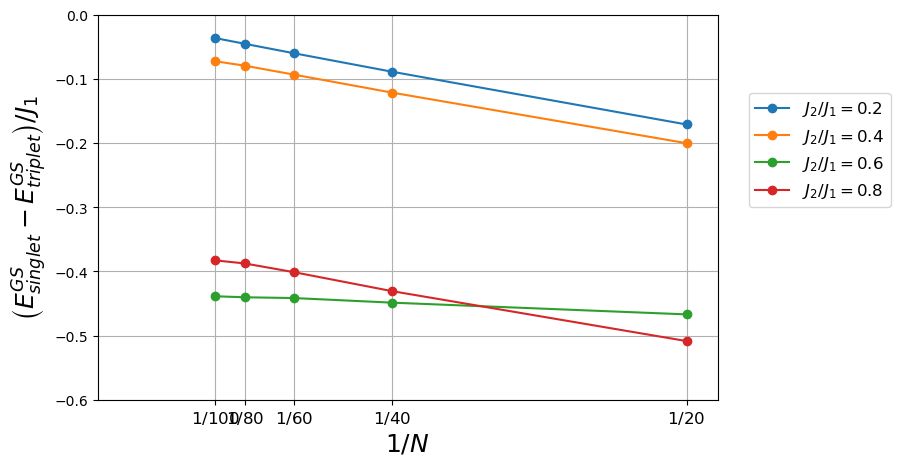

In [183]:
fig,ax = subplots(figsize=(8,5))
for i in 1:length(gs)
    ax.plot(1 ./Ns,E_singlet[:,i]-E_triplet[:,i],"-o",label=L"$J_2/J_1=$"*string(gs[i]))
end
# ax.set_xlim([0,1])
# ax.set_xscale("log")
ax.legend(loc=(1.05,0.5),fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=18)
ax.set_xticks(1 ./Ns)
ax.set_xticklabels([L"1/" * string(N) for N in Ns ], fontsize=12)
ax.set_ylabel(L"\left(E^{GS}_{singlet}-E^{GS}_{triplet}\right)/J_1",fontsize=18)
ax.set_xlim([0,1/19])
ax.set_ylim([-0.6,0])
# ax.set_xscale("log")
ax.grid()

gcf()

## 1-3
*Calculate the spin-spin correlations (i.e. the expectation value of $\langle\vec{S}_{x_0} \cdot \vec{S}_{x_0+x} \rangle$ as function of $x$) for different values of g across the phase transition. Show that for $g\leq g_c$ the correlations decay as a power law (i.e.  $1/x^\alpha$), while for $g > g_c$ the decay is exponential (i.e. $\sim\exp(-x\xi)$) . Use system sizes of $N = 200$ sites and calculate the correlations with respect to a site in the middle of the system to avoid boundary effects. (Recall that we are now working with open boundary conditions as opposed to all the calculations we performed using Exact Diagonalization.) For $g\leq g_c$ calculate the exponent $\alpha$, and for $g > g_c$ obtain the correlation length $\xi$. Note: to obtain the spin-spin correlations you can use the built in ITensor function `correlation matrix(psi,"Sz","Sz")` that calculates the full correlation matrix $\langle \psi|S^z_i S^z_j|\psi \rangle$ for every pair of sites $(i,j)$ in the system.*

In [76]:
N = 200
correlations = []
for (j,g) in enumerate(gs)
    sites = siteinds("S=1/2", N; conserve_qns=true)
    H = J1J2Hamiltonian(sites, g)
    
    state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
    psi0 = productMPS(sites, state0)
    @show flux(psi0)
    E ,psi = dmrg(H,psi0; nsweeps=20, maxdim=100, cutoff=1E-10)

    append!(correlations,[correlation_matrix(psi,"Sz","Sz") + 0.5* correlation_matrix(psi,"S+","S-") + 0.5*correlation_matrix(psi,"S-","S+")])
end

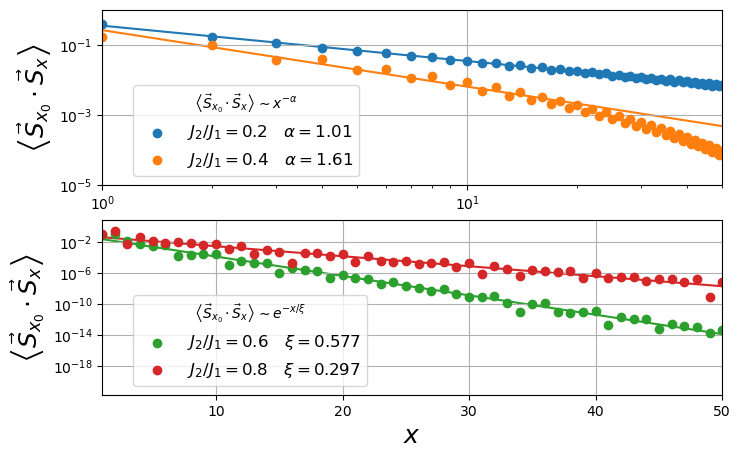

In [205]:
fig,ax = subplots(2,1,figsize=(8,5))
xx = LinRange(0,50,100)
p0 = [1.0, 0.0]
title=[L"$\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>\sim x^{-\alpha}$", L"$\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>\sim e^{-x/\xi}$"]
c = ["tab:blue","tab:orange","tab:green", "tab:red"]

for (i,g) in enumerate(gs)
    if g<0.5
        fit = curve_fit(m, log.(1:1:20), log.(abs.(correlations[i][100,101:120])) ,p0)
        ax[1].plot(exp.(xx),exp.(m(xx,fit.param)),color=c[i],zorder=1)
        ax[1].scatter(0:1:div(N,2),abs.(correlations[i][100,100:200]),
            zorder=2,color=c[i],
            label=L"$J_2/J_1=$"*string(g)*L"$\quad \alpha=$"*string(round(-fit.param[1],digits=2)))
    else
        fit = curve_fit(m, 1:1:50, log.(abs.(correlations[i][100,101:150])) ,p0)
        ax[2].plot(xx,exp.(m(xx,fit.param)),color=c[i],zorder=1)
        ax[2].scatter(0:1:div(N,2),abs.(correlations[i][100,100:200]),
            zorder=2,color=c[i],
            label=L"$J_2/J_1=$"*string(g)*L"$\quad \xi=$"*string(round(-fit.param[1],digits=3)))
    end
end
for i in 1:2
    ax[i].legend(loc=(0.05,0.05),fontsize=12, title=title[i])
    ax[i].set_ylabel(L"\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>",fontsize=18)
    ax[i].set_xlim([1,50])
    ax[i].set_xlabel(L"$x$", fontsize=18)
end
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim([1e-5,1])
ax[2].set_yscale("log")

ax[1].grid(zorder=0)
ax[2].grid(zorder=0)

gcf()

# Spin-1 chain - Haldane gap
*In this problem we will consider the spin-1 bilinear-biquadtatic model*
$$H=\sum_i J_1 \vec{S}_i\cdot\vec{S}_{i+1} + J_2 \left( \vec{S}_i\cdot\vec{S}_{i+1} \right)^2 $$
*As discussed in the tutorial and in Problem Set 2, for $J_2/J_1 = 1/3$ the model is exactly solvable,and the ground state can be written explicitly as an MPS of bind dimension $M = 2$. At this point you observed that the ground state is four-fold degenerate for open boundary conditions and that the edges feature fractionalized spin-1/2 states.*

*In this problem you will show that when $J_2\rightarrow0$ the system remains in the same phase, i.e. it is gapped, and hosts fractionalized edge mods.*

## 2-1
*Consider different values of $J_2$ ranging between $1/3$ and $0$ and show that the system remains gapped within this range. To this end, perform finite-size scaling of the bulk gap. Note that to probe the bulk gap in this case you will need to look at the $S^z = 2$ sector, as the lowest energy state in the $S^z = 1$ sector simply accumulates the extra spin at the edges of the system (you'll check this in the next section).*

In [214]:
function AKLTHamiltonian(sites, J2)
    N = length(sites)
    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the 1D quantum system
    for j = 1:N-1
        ampo += "Sz", j, "Sz", j+1
        ampo += 1/2, "S+", j, "S-", j+1
        ampo += 1/2, "S-", j, "S+", j+1
        
        ampo += J2, "Sz", j, "Sz", j+1, "Sz", j, "Sz", j+1
        ampo += J2/2, "Sz", j, "Sz", j+1, "S+", j, "S-", j+1
        ampo += J2/2, "S+", j, "S-", j+1, "Sz", j, "Sz", j+1
        ampo += J2/2, "Sz", j, "Sz", j+1, "S-", j, "S+", j+1
        ampo += J2/2, "S-", j, "S+", j+1, "Sz", j, "Sz", j+1
        ampo += J2/4, "S+", j, "S-", j+1 , "S+", j, "S-", j+1
        ampo += J2/4, "S+", j, "S-", j+1 , "S-", j, "S+", j+1
        ampo += J2/4, "S-", j, "S+", j+1 , "S-", j, "S+", j+1
        ampo += J2/4, "S-", j, "S+", j+1 , "S+", j, "S-", j+1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)
    return H
end

AKLTHamiltonian (generic function with 1 method)

In [ ]:
Ns = 16:4:20
J2s = [0.0, 0.1, 0.2, 0.3, 1/3]
E_0 = zeros(length(Ns),length(gs))
E_2 = zeros(length(Ns),length(gs))

for (i,N) in enumerate(Ns)
    for (j,J2) in enumerate(J2s)
        sites = siteinds("S=1", N; conserve_qns=true)
        H = AKLTHamiltonian(sites, J2)
        
        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]

        # psi0 = productMPS(sites, state0)
        psi0 = randomMPS(sites,state0,linkdims=2)
        @show flux(psi0)
        E_0[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=10, cutoff=1E-10)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "Up"

        psi0 = randomMPS(sites,state0,linkdims=2)
        @show flux(psi0)
        E_2[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=10, cutoff=1E-10)
    end
end

## 2-2
*For the same values of $J_2$ as above, calculate the gap between the $S^z = 1$ and $S^z = 0$ sectors.Show that the gap decays exponentially with system size (i.e. the states are degenerate in the thermodynamic limit). Calculate the local expectation value of $S^z$ along the chain in the lowest energy state with $S^z = 1$ and show that the total spin accumulated near each edge is $\pm 1/2$.*